In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model, svm
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
from brokenaxes import brokenaxes
import pingouin as pg
import colorsys

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_COLOR_DESAT = '#D98C90'
CR_COLOR_DESAT = '#A0A0A0'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#,'#6ded94','#50d979','#36bf5f']


did_not_learn_animals = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']#,'DS_15','DS_19']


#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = '..\\..\\Data\\Analysis_Cache'
ops_directory = '..\\..\\Data\\Opsin_Cache'
beh_directory = '..\\..\\Data\\Behavioor'

stim25sdecodingfilename = '..\\..\\Data\\stimdecoding_25s.csv'
stim25sopsinondecodingfilename = '..\\..\\Data\\stimdecoding_25s_opsin_on.csv'
stim25sopsinoffdecodingfilename = '..\\..\\Data\\stimdecoding_25s_opsin_off.csv'

current_version = 1 #Aug 12th, 2023

stdfont = 14
stdyfrac = 0.06

In [2]:
animals = np.concatenate((dualanimalnames,['DS_15','DS_19','AE_267']))

In [3]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

C:\Users\4thgr\Documents\TothSidleck2024\Notebooks\EDF 7\../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in scalar divide
  pc = (hit+creject)/(hit+miss+falarm+creject)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite v

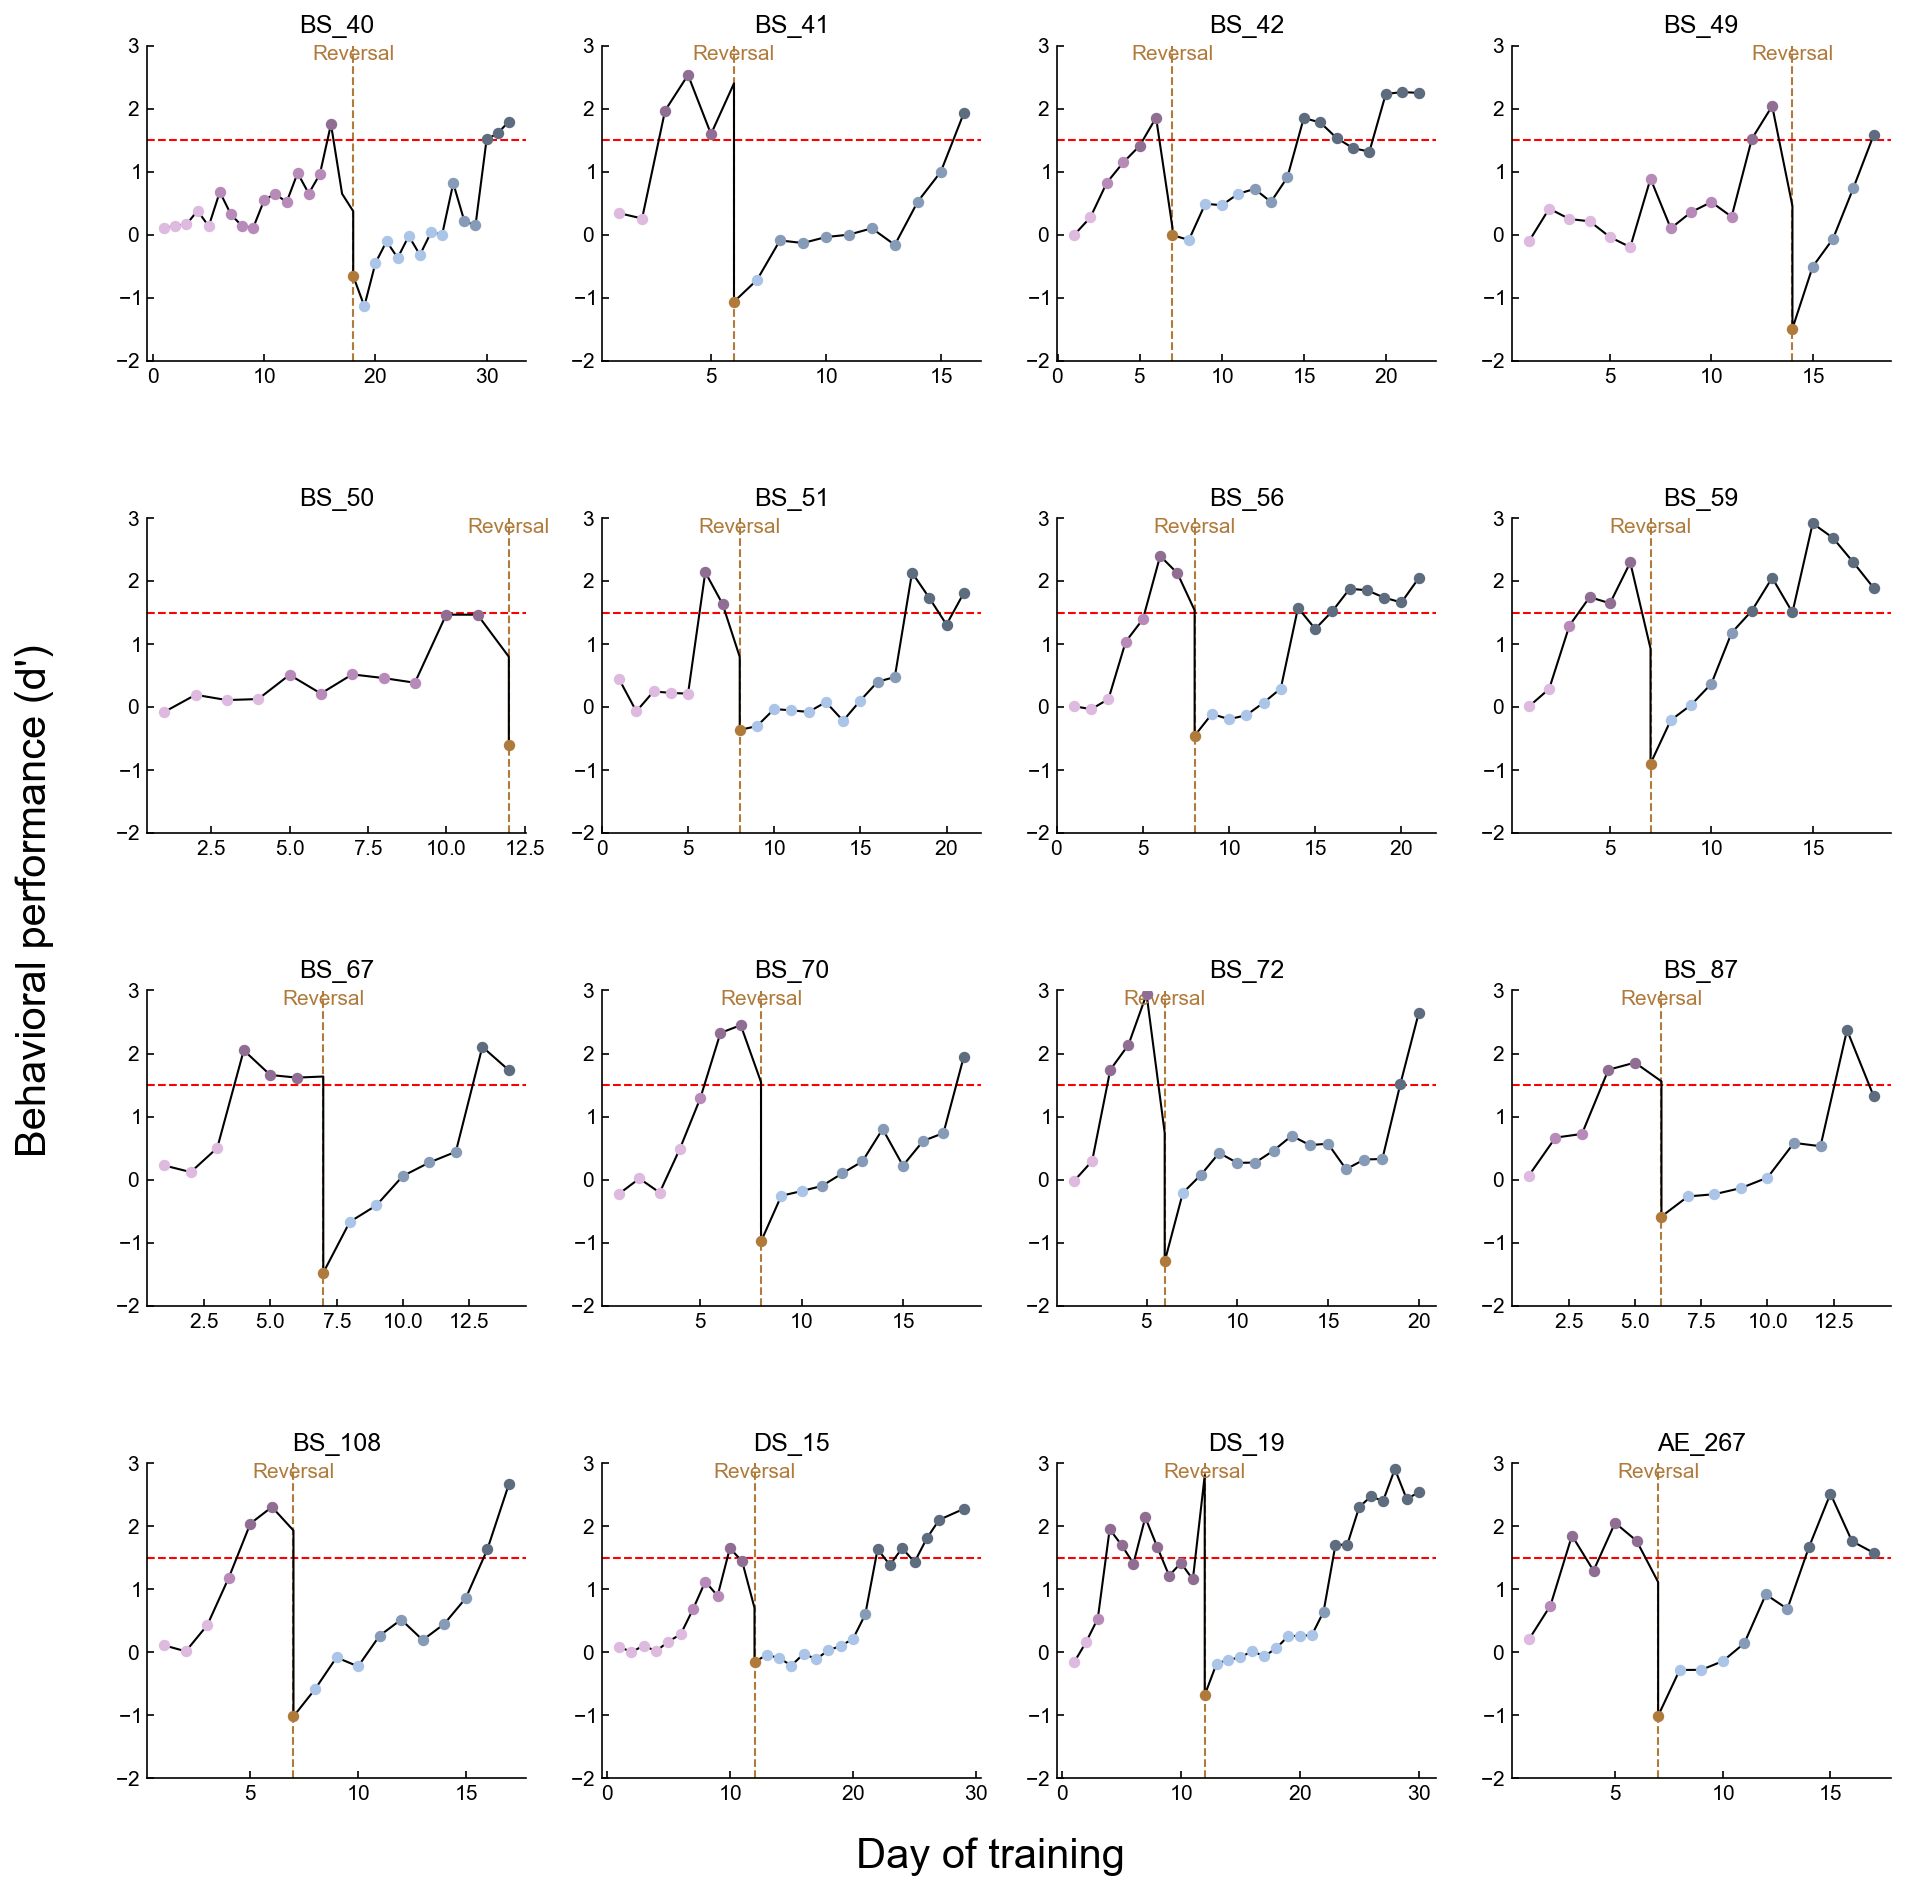

In [4]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True)
#plt.savefig(os.path.join('D:\\\\TempFigures','All ephys animals learning phases.pdf'),transparent=False,facecolor="white")

In [5]:
EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no beahvior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
        
    if sessionfile.meta.animal not in animals:
        continue
    
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)

100%|██████████| 740/740 [00:35<00:00, 20.61it/s]


In [6]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_early_days:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_late_days:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_expert_days:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1829/1829 [01:14<00:00, 24.48it/s]


errors for: []


# Choice

In [7]:
#this function calculates pval for one cluster(one cell)
def calculate_choice_NCR_CR_pval(sessionfile,clust):
    
    #convert window(100ms) in samples
    sessionfile.meta.fs #30000 samples / second from blackrock
    window = sessionfile.meta.fs * 0.1
    
    allConditions = ilep.getAllConditions(sessionfile,clust)
    trials_to_use = allConditions['go'].trials

    if len(trials_to_use) < 30:
        return np.nan,np.nan,np.nan
    
    #create array for stimulus period
    #tone play start time
    onset_window_start_time = np.zeros(len(trials_to_use))
    for idx, trial in enumerate(trials_to_use):
        onset_window_start_time[idx] = sessionfile.trials.response[trial] - window*0.5

    #tone play end time
    onset_window_end_time = onset_window_start_time + window
    #offset window start time
    offset_window_start_time = onset_window_end_time
    #offset window end time
    offset_window_end_time = offset_window_start_time + window
    #stimulus array
    stimulus_array = np.zeros([len(onset_window_start_time),2,2])
    for i in range(len(onset_window_start_time)):
        stimulus_array[i] = [[onset_window_start_time[i],onset_window_end_time[i]],
                             [offset_window_start_time[i],offset_window_end_time[i]]
                            ]

    #create array for baseline period
    baseline_reference_window_start_time = np.zeros(len(trials_to_use))
    for idx, trial in enumerate(trials_to_use):
        baseline_reference_window_start_time[idx] = sessionfile.trials.starts[trial]
    base_window1_start = baseline_reference_window_start_time - 3*window
    base_window1_end = baseline_reference_window_start_time - 2*window
    base_window2_start = base_window1_end
    base_window2_end = baseline_reference_window_start_time - 1*window
    base_window3_start = base_window2_end
    base_window3_end = baseline_reference_window_start_time

    baseline_array = np.zeros([len(base_window1_start),3,2])
    for i in range(len(onset_window_start_time)):
        baseline_array[i] = [[base_window1_start[i],base_window1_end[i]],
                             [base_window2_start[i],base_window2_end[i]],
                             [base_window3_start[i],base_window3_end[i]],
                            ]

    #evaluate spike count within stimulus window
    spikecounts_stimuluswindow = np.zeros((len(onset_window_start_time),2))

    for idx, t in enumerate(stimulus_array):
        #print(t[0][0])

        #spike count from onset window
        spikecount_onsetwindow = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[0][0],endtime=t[0][1]))

        #spike count from offset window
        spikecount_offsetwindow = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[1][0],endtime=t[1][1]))

        spikecounts_stimuluswindow[idx][0]=spikecount_onsetwindow
        spikecounts_stimuluswindow[idx][1]=spikecount_offsetwindow

    #evaluate spike count within baseline window
    spikecounts_basewindow = np.zeros((len(onset_window_start_time),3))

    for idx, t in enumerate(baseline_array):
        #print(t[0][0])

        #spike count from window1
        spikecount_base_window1 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[0][0],endtime=t[0][1]))

        #spike count from window2
        spikecount_base_window2 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[1][0],endtime=t[1][1]))

        #spike count from window3
        spikecount_base_window3 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[2][0],endtime=t[2][1]))

        spikecounts_basewindow[idx][0]=spikecount_base_window1
        spikecounts_basewindow[idx][1]=spikecount_base_window2
        spikecounts_basewindow[idx][2]=spikecount_base_window3

    ###### CODE BELOW HERE SHOULD LOOP 5000 TIMES 
    iterations = 5000
    #spikecounts_diff_mean_arr = []

    CR_evok_appear=0
    CR_sup_appear=0
    NCR_appear=0

    for i in range(iterations):

        #1.subsampled 90% of the spike count changes from baseline,
        #2.calculated the mean of these values, repeated this process 5000 times 

        #1.
        #subsampled 90% trials
        trials = range(len(spikecounts_stimuluswindow))
        trials_perm = np.random.permutation(trials)
        trials_subsamp = trials_perm[range(int(0.9*len(trials_perm)))]

        #calculate spike count changes from baseline in the subsample
        spikecounts_diff = []
        for trial_idx in trials_subsamp:
            random_stimulus = spikecounts_stimuluswindow[trial_idx][np.random.randint(2)]
            random_base = spikecounts_basewindow[trial_idx][np.random.randint(3)]
            spikecounts_diff.append(random_stimulus-random_base)
            
        #2. 
        #calculate the mean of the spike counts diff  
        spikecounts_diff_mean = np.mean(spikecounts_diff)
        #calculate the # of appearance in each categotiry in 5000 iterations
        if spikecounts_diff_mean > 0.1:
            CR_evok_appear+=1
        elif spikecounts_diff_mean < -0.1:
            CR_sup_appear+=1
        else:
            NCR_appear+=1
            
    p_value_evoked = CR_evok_appear/(iterations)
    p_value_suppressed = CR_sup_appear/(iterations)
    p_value_NCR = NCR_appear/(iterations)
    return p_value_evoked, p_value_suppressed, p_value_NCR

In [8]:
animal_list = []
session_list = []
cluster_ID_list = []
ChoiceMod_list = []
category_list = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if EILphases[idx] not in ['pre early','pre late','pre expert','post early','post late','post expert']:
        continue
    if sessionfile.meta.animal not in dualanimalnames:
        continue
    
    p_evk,p_sup,p_ncr = calculate_choice_NCR_CR_pval(sessionfile,clust)

    try:
        ChoiceMod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation_choice
    except Exception as e:
        ChoiceMod=np.nan
        print(e)
    if not np.isfinite(ChoiceMod):
        continue

    category = 'N/A'
    if p_evk >= 0.95:
        category = 'CR (enhanced)'
    elif p_sup >= 0.95:
        category = 'CR (suppressed)'
    elif p_ncr >= 0.95:
        category = 'NCR'
    else:
        category = 'Inconclusive'

    animal_list.append(sessionfile.meta.animal)
    session_list.append(session)
    cluster_ID_list.append(clust)
    ChoiceMod_list.append(ChoiceMod)
    category_list.append(category)

1829it [2:25:13,  4.76s/it]


In [9]:
df_dict = dict()
df_dict['animal'] = animal_list
df_dict['session'] = session_list
df_dict['cluster ID'] = cluster_ID_list
df_dict['Choice modulation'] = ChoiceMod_list
df_dict['category'] = category_list
df = pd.DataFrame(df_dict)

In [10]:
df

,animal,session,cluster ID,Choice modulation,category
0,BS_108,BS_108_1_AC.pickle,2,3.030303e+00,CR (enhanced)
1,BS_108,BS_108_1_AC.pickle,8,8.595275e-16,Inconclusive
2,BS_108,BS_108_1_AC.pickle,9,8.145161e+00,CR (enhanced)
3,BS_108,BS_108_1_AC.pickle,14,4.765840e+00,CR (enhanced)
4,BS_108,BS_108_1_AC.pickle,34,1.005376e+01,CR (enhanced)
...,...,...,...,...,...
1114,BS_87,BS_87_9_AC.pickle,109,4.992104e-17,NCR
1115,BS_87,BS_87_9_AC.pickle,120,1.438849e-01,NCR
1116,BS_87,BS_87_9_AC.pickle,128,5.882353e-01,NCR
1117,BS_87,BS_87_9_AC.pickle,131,5.259087e-01,NCR


In [11]:
df.to_csv('..\\..\\Source Data Files\EDF 7c.csv')

In [21]:
ChoiceMod_evoked = []
ChoiceMod_suppressed = []
ChoiceMod_NCR = []
ChoiceMod_inc = []

df_evoked = df[df['category']=='CR (enhanced)']
ChoiceMod_evoked = df_evoked['Choice modulation'].values

df_suppressed = df[df['category']=='CR (suppressed)']
ChoiceMod_suppressed = df_suppressed['Choice modulation'].values

df_NCR = df[df['category']=='NCR']
ChoiceMod_NCR = df_NCR['Choice modulation'].values

df_inc = df[df['category']=='Inconclusive']
ChoiceMod_inc = df_inc['Choice modulation'].values

In [22]:
ChoiceMod_thresh = 0.828865188731339

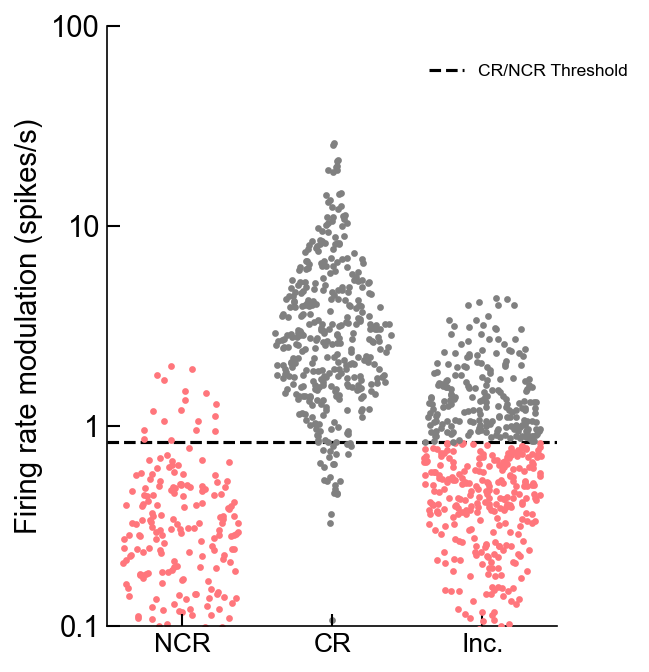

In [23]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3, 4, left=.3, bottom=.3, right=0, top=0)

################################################################################################################

X,Y = ilep.violin(ilep.rmnan(np.abs(ChoiceMod_NCR)),log=True)
ax.scatter(X,Y,s=5,color=NCR_COLOR)

X,Y = ilep.violin(np.concatenate((ilep.rmnan(np.abs(ChoiceMod_evoked)),ilep.rmnan(np.abs(ChoiceMod_suppressed)))),log=True)
ax.scatter(X+1,Y,s=5,color=CR_COLOR)

X,Y = ilep.violin(ilep.rmnan(np.abs(ChoiceMod_inc)),log=True)
up_mask = np.greater(Y,ChoiceMod_thresh)
ax.scatter(X[up_mask]+2,Y[up_mask],s=5,color=CR_COLOR,zorder=4)
ax.scatter(X[~up_mask]+2,Y[~up_mask],s=5,color=NCR_COLOR,zorder=3)

ax.axhline(0.828865188731339,linestyle='--',color='k',zorder=-10,label='CR/NCR Threshold')

################################################################################################################

labels = ['NCR','CR','Inc.']

ax.set_yscale('log',subs=[])
ax.set_ylim([0.1,100])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ylab = ax.set_ylabel('Firing rate modulation (spikes/s)')

ax.set_xlim([-0.5,2.5])
ax.set_xticks([0,1,2])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

# xtick_pos_pre = ax.get_xticks()[1]
# xtick_pos_post = ax.get_xticks()[4]
# Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
# t1 = ax.text(xtick_pos_pre, Yval, 'Pre-rev', ha='center', va='bottom', fontsize=stdfont,color='k')
# t2 = ax.text(xtick_pos_post, Yval, 'Post-rev', ha='center', va='bottom',  fontsize=stdfont,color='k')
# ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
# ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

lgd = ax.legend(frameon=False,loc=(0.7,.9))

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
# Y = np.mean(ax.get_ylim())
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,lgd]
# fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','CR NCR Choice Threshold Schematic V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [24]:
ChoiceModFR_NCR = ilep.rmnan(np.abs(ChoiceMod_NCR))
ChoiceModFR_CR = np.concatenate((ilep.rmnan(np.abs(ChoiceMod_evoked)),ilep.rmnan(np.abs(ChoiceMod_suppressed))))

ChoiceModFR_NCR = np.vstack((ChoiceModFR_NCR,np.zeros_like(ChoiceModFR_NCR))).T
ChoiceModFR_CR = np.vstack((ChoiceModFR_CR,np.zeros_like(ChoiceModFR_CR))).T

X = np.r_[ChoiceModFR_NCR,ChoiceModFR_CR]
Y = np.r_[np.zeros(len(ChoiceModFR_NCR)),np.ones(len(ChoiceModFR_CR))]

In [25]:
clf = svm.SVC(kernel='linear')
clf.fit(X, Y)
w = clf.coef_[0]
x_0 = -clf.intercept_[0]/w[0]
margin = w[0]

print(f"Threshold is {x_0}")

Threshold is 0.8573658517995735


In [ ]:
print('finished')